Using device: cpu
L shape: torch.Size([10000, 10000])


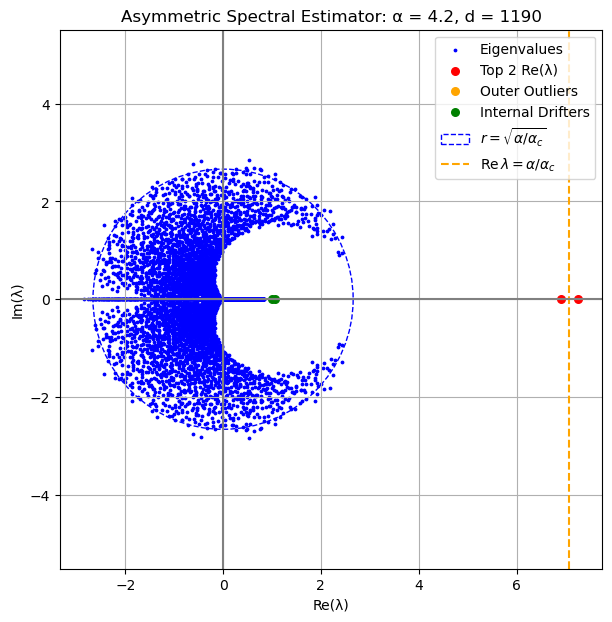


[Method 3: Single Eigenvector Alignment Scores]
  Eigenvalue  Index  Alignment Score
0     Green1   3503         0.515910
1     Green2   3729         0.530879
2       Red1      0         0.435277
3       Red2      1         0.423731

[Method 4: Eigenvector Pair Alignment Scores]
            Pair         Eigenvalue1         Eigenvalue2  Alignment Score
0  Green1-Green2  1.069363+0.000000j  0.992211+0.000000j         0.740266
4    Green2-Red2  0.992211+0.000000j  6.908112+0.000000j         0.679253
1    Green1-Red1  1.069363+0.000000j  7.248757+0.000000j         0.674999
5      Red1-Red2  7.248757+0.000000j  6.908112+0.000000j         0.607466
3    Green2-Red1  0.992211+0.000000j  7.248757+0.000000j         0.541695
2    Green1-Red2  1.069363+0.000000j  6.908112+0.000000j         0.530273


/var/folders/kl/6hy0lk_14w14xqln8byr8l940000gn/T/ipykernel_17050/1604702444.py:292: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


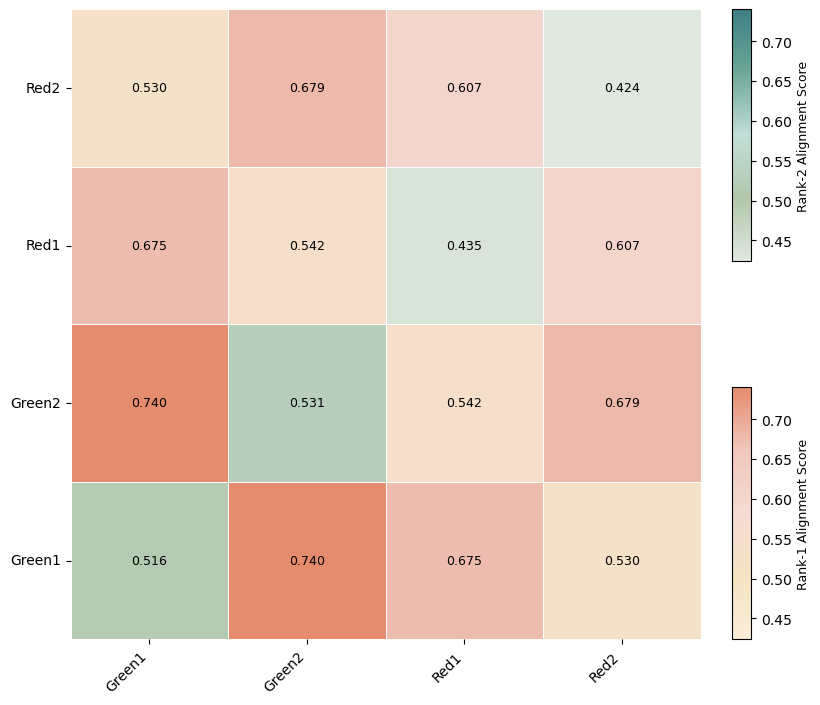

In [ ]:
# asymmetric_spectral_estimator_updated.py

import os
import random
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import kv as besselk
from scipy.linalg import qr
from numpy.linalg import norm
from itertools import combinations
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Set random seed and computational device
def set_seed(seed=1000):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(1000)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Parameter setup and data generation
n, p = 5000, 2
alpha = 4.2
alpha_c = 0.59375
d = int(n / alpha)
X = torch.randn(n, d, device=device) / np.sqrt(d)
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
y = Z[:, 0] * Z[:, 1]

# Construct G(y) and spectral matrix L
y_np = y.detach().cpu().numpy()
abs_y = np.abs(y_np)
K0, K1 = besselk(0, abs_y), besselk(1, abs_y)
lambda_y = abs_y * (K1 / (K0 + 1e-6)) - 1
lambda_y[np.isnan(lambda_y)] = 0

G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_np
G_y_np[:, 1, 0] = y_np
G_y = torch.tensor(G_y_np, device=device)

XXT = X @ X.T
XXT.fill_diagonal_(0.0)
L_blocks = XXT[:, :, None, None] * G_y[None, :, :, :]
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)
print(f"L shape: {L.shape}")

# Eigenvalue and eigenvector computation
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
eigvals_real_only = [z for z in eigvals_np if np.isclose(z.imag, 0.0, atol=1e-6)]

# Eigenvalue classification
R = np.sqrt(alpha / alpha_c)
thresh = alpha / alpha_c

outside = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
red_vals = sorted(outside, key=lambda z: z.real, reverse=True)[:2]
orange_vals = [z for z in outside if z not in red_vals]
green_candidates = [z for z in eigvals_real_only if abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:2]

green_labels = [(f"Green{i+1}", z) for i, z in enumerate(green_vals)]
orange_labels = [(f"Orange{i+1}", z) for i, z in enumerate(orange_vals)]
red_labels = [(f"Red{i+1}", z) for i, z in enumerate(red_vals)]
all_labels = green_labels + orange_labels + red_labels
label_order = [label for label, _ in all_labels]

# Spectral plot visualization
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, s=3, color='blue', label='Eigenvalues')
plt.scatter([z.real for _, z in red_labels], [z.imag for _, z in red_labels], color='red', s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for _, z in orange_labels], [z.imag for _, z in orange_labels], color='orange', s=30, label="Outer Outliers")
plt.scatter([z.real for _, z in green_labels], [z.imag for _, z in green_labels], color='green', s=30, label="Internal Drifters")
circle = plt.Circle((0, 0), R, color='blue', fill=False, linestyle='--', label=rf'$r = \sqrt{{\alpha / \alpha_c}}$')
plt.gca().add_artist(circle)
plt.axvline(x=thresh, color='orange', linestyle='--', label=rf'$\mathrm{{Re}}\,\lambda = \alpha / \alpha_c$')
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# Evaluation functions (methods 3 and 4)
import numpy as np
import pandas as pd
from scipy.linalg import qr
from numpy.linalg import norm

def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

def map_multiple_eigvecs_to_2d(eigvecs_np, eigvals_np, selected_eigvals, X, W_star, eigval_to_label, p=2):
    """
    Map multiple eigenvectors into a 2D representation and compute alignment scores.

    Parameters:
        eigvecs_np: ndarray, shape (n*p, n*p) — eigenvector matrix
        eigvals_np: ndarray, shape (n*p,) — eigenvalues
        selected_eigvals: list — selected eigenvalues for evaluation
        X: ndarray, shape (n, d) — input samples
        W_star: ndarray, shape (d, p) — ground-truth signal subspace
        eigval_to_label: dict — mapping from eigenvalue to label
        p: int — subspace dimension, default 2

    Returns:
        pd.DataFrame — results containing labels, indices, and alignment scores
    """
    n, d = X.shape
    results = []

    # Stack ground-truth subspace for 2D comparison
    W_star_2d = np.vstack([W_star[:, i].reshape(-1,1) for i in range(p)])

    for val in selected_eigvals:
        idx = np.argmin(np.abs(eigvals_np - val))
        v = eigvecs_np[:, idx]  # shape (n*p,)
        V = v.reshape(n, p)

        if p == 1:
            mapped_vec = X.T @ V[:, 0]         
            mapped_vec = mapped_vec.reshape(d, 1)
        elif p == 2:
            v0 = X.T @ V[:, 0]
            v1 = X.T @ V[:, 1]
            mapped_vec = np.vstack([v0.reshape(-1,1), v1.reshape(-1,1)])
        else:
            raise NotImplementedError("Only p=1 or p=2 is supported")

        eps = 1e-12
        mapped_vec /= (norm(mapped_vec, axis=0, keepdims=True) + eps)

        score = alignment_score(mapped_vec, W_star_2d)
        label = eigval_to_label.get(val, f"Unknown_{val}")
        results.append({"Eigenvalue": label, "Index": idx, "Alignment Score": score})

    return pd.DataFrame(results)

def joint_map_and_align(eigvecs_np, eigvals_np, pairs, X, W_star, p=2):
    """
    Map pairs of eigenvectors into the original space and compute joint alignment scores.

    Parameters:
        eigvecs_np: ndarray, shape (np, np) — eigenvectors
        eigvals_np: ndarray, shape (np,) — eigenvalues
        pairs: list of tuples, [(label1, eigval1, label2, eigval2), ...]
        X: ndarray, (n, d) — input samples
        W_star: ndarray, (d, p) — ground-truth signal subspace
        p: int, default 2

    Returns:
        pd.DataFrame — joint alignment scores for eigenvector pairs
    """
    n, d = X.shape
    results = []

    # Ground-truth subspace stacked for 2D comparison
    W_star_2d = np.vstack([W_star[:, i].reshape(-1, 1) for i in range(p)])

    for (label1, val1, label2, val2) in pairs:
        idx1 = np.argmin(np.abs(eigvals_np - val1))
        idx2 = np.argmin(np.abs(eigvals_np - val2))

        v1 = eigvecs_np[:, idx1]
        v2 = eigvecs_np[:, idx2]

        V1 = v1.reshape(n, p)
        V2 = v2.reshape(n, p)

        V_combined = np.stack([V1, V2], axis=2)

        mapped_columns = []
        for pi in range(p):
            mapped_columns.append(X.T @ V_combined[:, pi, :])  
        W_hat = np.vstack(mapped_columns)

        W_hat /= (norm(W_hat, axis=0, keepdims=True) + 1e-12)

        Q1, _ = qr(W_hat, mode='economic')
        Q2, _ = qr(W_star_2d, mode='economic')
        overlap = Q1.T @ Q2
        _, s, _ = np.linalg.svd(overlap)
        score = np.mean(s)

        results.append({
            "Pair": f"{label1}-{label2}",
            "Eigenvalue1": val1,
            "Eigenvalue2": val2,
            "Alignment Score": score
        })

    return pd.DataFrame(results)

# Evaluation and heatmap visualization
eigval_to_label = {val: label for label, val in all_labels}
selected_eigvals = list(eigval_to_label.keys())

df_single = map_multiple_eigvecs_to_2d(
    eigvecs_np, eigvals_np, selected_eigvals,
    X.cpu().numpy(), W_star.cpu().numpy(),
    eigval_to_label, p=2
)

all_pairs = list(combinations(all_labels, 2))
pairs = [(l1, v1, l2, v2) for (l1, v1), (l2, v2) in all_pairs]

df_pair = joint_map_and_align(
    eigvecs_np, eigvals_np, pairs,
    X.cpu().numpy(), W_star.cpu().numpy(), p=2
)

print("\n[Method 3: Single Eigenvector Alignment Scores]")
print(df_single)
print("\n[Method 4: Eigenvector Pair Alignment Scores]")
print(df_pair.sort_values(by="Alignment Score", ascending=False))

# Heatmap visualization
heatmap_df = pd.DataFrame(np.nan, index=label_order, columns=label_order)
for _, row in df_single.iterrows():
    heatmap_df.loc[row["Eigenvalue"], row["Eigenvalue"]] = row["Alignment Score"]
for _, row in df_pair.iterrows():
    a, b = row["Pair"].split("-")
    heatmap_df.loc[a, b] = heatmap_df.loc[b, a] = row["Alignment Score"]

diag_colors = ["#FAEED9", "#F5E3C2", "#F5DBD4", "#F0C7BC", "#E58B6E"]
offdiag_colors = ["#DFE9DF", "#B2C6AB", "#C2DED7", "#6DA798", "#3E7F84"]
diag_cmap = LinearSegmentedColormap.from_list("diag_cmap", diag_colors)
offdiag_cmap = LinearSegmentedColormap.from_list("offdiag_cmap", offdiag_colors)
mask_diag = pd.DataFrame(True, index=label_order, columns=label_order)
np.fill_diagonal(mask_diag.values, False)

fig, ax = plt.subplots(figsize=(8, 7))
vmin, vmax = np.nanmin(heatmap_df.values), np.nanmax(heatmap_df.values)
sns.heatmap(heatmap_df, mask=mask_diag, cmap=offdiag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)
cbar_ax1 = inset_axes(ax, width="3%", height="40%", loc='upper right',
                      bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
fig.colorbar(plt.cm.ScalarMappable(cmap=offdiag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)),
             cax=cbar_ax1).set_label("Rank-2 Alignment Score", fontsize=9)

sns.heatmap(heatmap_df, mask=~mask_diag, cmap=diag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)
cbar_ax2 = inset_axes(ax, width="3%", height="40%", loc='lower right',
                      bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
fig.colorbar(plt.cm.ScalarMappable(cmap=diag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)),
             cax=cbar_ax2).set_label("Rank-1 Alignment Score", fontsize=9)

for i in range(len(label_order)):
    for j in range(len(label_order)):
        val = heatmap_df.iloc[i, j]
        if not np.isnan(val):
            ax.text(j + 0.5, i + 0.5, f"{val:.3f}", ha='center', va='center', fontsize=9)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()
plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.90, top=0.95, bottom=0.05)
plt.show()


Subspace alignment score: 0.5542


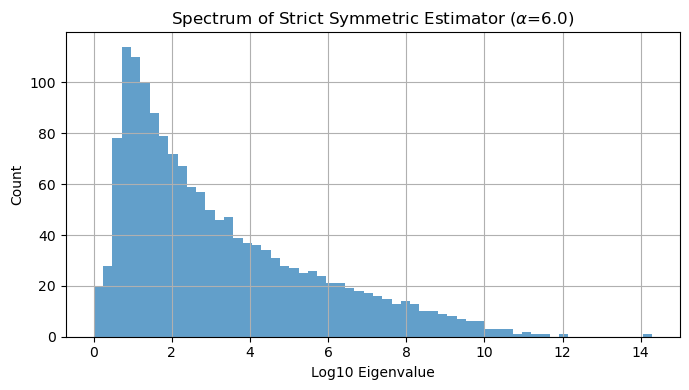


[Individual Eigenvector Alignment Scores]
      Type        λ  Alignment Score
0  eig1658  10.6393           0.0068
1  eig1659  10.7424           0.0051
2  eig1660  10.9844           0.0223
3  eig1661  11.0279           0.0787
4  eig1662  11.3725           0.0120
5  eig1663  11.5500           0.1934
6  eig1664  11.9629           0.2627
7  eig1665  14.2920           0.2973

[Eigenvector Pair Subspace Alignment Scores]
               Type                  λ Pair  Alignment Score
0   eig1658+eig1659  (10.639304, 10.742441)           0.0369
1   eig1658+eig1660  (10.639304, 10.984408)           0.0234
2   eig1658+eig1661  (10.639304, 11.027896)           0.0232
3   eig1658+eig1662  (10.639304, 11.372451)           0.0471
4   eig1658+eig1663  (10.639304, 11.549953)           0.0173
5   eig1658+eig1664  (10.639304, 11.962899)           0.3530
6   eig1658+eig1665  (10.639304, 14.292014)           0.3916
7   eig1659+eig1660  (10.742441, 10.984408)           0.0423
8   eig1659+eig1661  (10.7424

In [8]:
import torch
import numpy as np
import pandas as pd
from scipy.special import kv  # Bessel function Kν
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

# ========== Parameters ==========
n, d, p = 5000, 833, 2
alpha = n / d
np.random.seed(42)
device = torch.device("cpu")

# ========== Step 1: Generate Data ==========
torch.manual_seed(42)
W_star = torch.nn.functional.normalize(torch.randn(d, p), dim=0)
X = torch.randn(n, d)
Z = X @ W_star
y = (Z[:, 0] * Z[:, 1]).numpy()  # scalar response

# ========== Step 2: Construct T(y) using adjustable Bessel approximation ==========
def construct_T_y_adjustable(y_i, gamma=1, clip=1e-2, scale=5):
    y_scaled = scale * y_i
    abs_y = np.abs(y_scaled) + 1e-8
    K0 = kv(0, abs_y)
    K1 = kv(1, abs_y)
    r = abs_y * (K1 / (K0 + 1e-6))
    r = np.clip(r, clip, None)
    return torch.tensor([
        [r, gamma * y_scaled],
        [gamma * y_scaled, r]
    ], dtype=torch.float32)

# ========== Step 3: Construct Spectral Matrix ==========
I2 = torch.eye(2)
L_sym = torch.zeros((2*d, 2*d))

for i in range(n):
    x_i = X[i].reshape(d, 1)
    kron_x = torch.kron(I2, x_i)  # (2d, 2)
    T_yi = construct_T_y_adjustable(y[i], gamma=1, clip=1e-2, scale=5.0)
    L_sym += kron_x @ T_yi @ kron_x.T

L_sym /= n

# ========== Step 4: Spectral Decomposition ==========
eigvals_sym, eigvecs_sym = torch.linalg.eigh(L_sym)
top_vals, indices = torch.topk(eigvals_sym, p)
U_top = eigvecs_sym[:, indices]  # (2d, p)

# ========== Step 5: Subspace Alignment Score ==========
def elevate_W_star_to_symmetric(W_star):
    return np.vstack([
        np.hstack([W_star, np.zeros_like(W_star)]),
        np.hstack([np.zeros_like(W_star), W_star])
    ])

U_top_np = U_top.numpy()
W_sym_np = elevate_W_star_to_symmetric(W_star.numpy())
Q1, _ = np.linalg.qr(U_top_np)
Q2, _ = np.linalg.qr(W_sym_np)
overlap = Q1.T @ Q2
subspace_score = np.linalg.norm(overlap, 'fro')**2 / p

print("Subspace alignment score:", round(subspace_score, 4))

# ========== Step 6: Plot Spectrum ==========
eigvals_np = eigvals_sym.numpy()
eigvals_pos = eigvals_np[eigvals_np > 1e-12]  # 排除非正值（含 0）

plt.figure(figsize=(7, 4))
plt.hist(eigvals_pos, bins=60, alpha=0.7)
plt.title(f"Spectrum of Strict Symmetric Estimator ($\\alpha$={alpha:.1f})")
plt.xlabel("Log10 Eigenvalue")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


# ========== Step 7: Unified Evaluation ==========

def elevate_vector(v, position='top', d=None):
    if d is None:
        d = v.shape[0]
    if position == 'top':
        return np.concatenate([v, np.zeros(d)])
    else:
        return np.concatenate([np.zeros(d), v])

def evaluate_alignment_unified(eig_vals, eig_vecs, W_star, top_k=8, mode='symmetric'):
    d, p = W_star.shape
    W_sym_np = elevate_W_star_to_symmetric(W_star.numpy())
    Q_true, _ = np.linalg.qr(W_sym_np[:, :p])  # ✅ 正确使用 p=2 维的信号空间


    indices = np.argsort(eig_vals)[-top_k:]
    individual_scores = []

    for i in indices:
        vec = eig_vecs[:, i]  # 取一个谱向量 (2d,)
        
        # === reshape 为 d × 2 的矩阵 ===
        try:
            V = vec.reshape(2, d).T  # 变为 d × 2
        except:
            print(f"Error reshaping eigenvector {i}, shape = {vec.shape}")
            continue

        # === 升维为 2d × 2，与真实空间对齐 ===
        W_est = elevate_W_star_to_symmetric(V)  # (2d × 2)
        Q_est, _ = np.linalg.qr(W_est)
        overlap = Q_est.T @ Q_true
        align_score = np.linalg.norm(overlap, 'fro')**2 / p
        individual_scores.append((f"eig{i}", eig_vals[i], align_score))

        

    # === pairwise 部分不变 ===
    pair_scores = []
    for i, j in combinations(indices, 2):
        vi = eig_vecs[:, i]
        vj = eig_vecs[:, j]
        if mode == 'asymmetric':
            vi = elevate_vector(vi, 'top', d=d)
            vj = elevate_vector(vj, 'top', d=d)
        V = np.stack([vi, vj], axis=1)
        Q, _ = np.linalg.qr(V)
        Q_torch = torch.tensor(Q, dtype=torch.float32)
        W_sym = torch.tensor(W_sym_np, dtype=torch.float32)
        proj = Q_torch @ Q_torch.T @ W_sym
        align_score = (torch.norm(proj) / torch.norm(W_sym)).item()
        pair_scores.append((f"eig{i}+eig{j}", (eig_vals[i], eig_vals[j]), align_score))

    individual_df = pd.DataFrame(individual_scores, columns=["Type", "λ", "Alignment Score"])
    pair_df = pd.DataFrame(pair_scores, columns=["Type", "λ Pair", "Alignment Score"])
    return individual_df, pair_df


# ========== Step 8: Run Unified Evaluation ==========
eigvals_np = eigvals_sym.numpy()
eigvecs_np = eigvecs_sym.numpy()

individual_df, pair_df = evaluate_alignment_unified(
    eigvals_np, eigvecs_np, W_star, top_k=8, mode='symmetric'
)

print("\n[Individual Eigenvector Alignment Scores]")
print(individual_df.round(4))

print("\n[Eigenvector Pair Subspace Alignment Scores]")
print(pair_df.round(4))


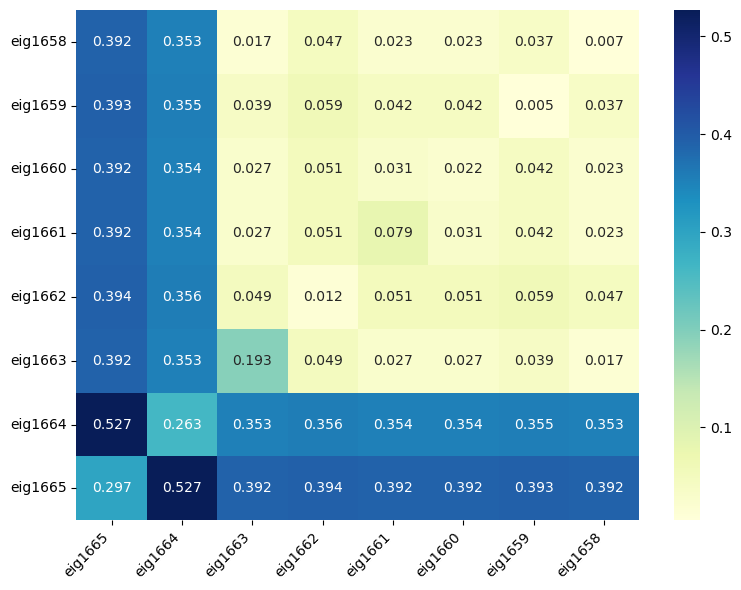

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_alignment_heatmap(pair_df, individual_df):
    """
    Plot the alignment heatmap for the symmetric spectral estimator.
    The x-axis is ordered from eig3999 → eig3992, 
    and the y-axis from eig3992 → eig3999.
    No title is included.
    """
    # Extract all unique labels
    labels = sorted(set([t.split('+')[0] for t in pair_df['Type']] + 
                        [t.split('+')[1] for t in pair_df['Type']]))

    # Initialize a symmetric DataFrame
    heatmap_df = pd.DataFrame(np.nan, index=labels, columns=labels)

    # Fill in alignment scores for eigenvalue pairs
    for _, row in pair_df.iterrows():
        e1, e2 = row["Type"].split("+")
        score = row["Alignment Score"]
        heatmap_df.loc[e1, e2] = score
        heatmap_df.loc[e2, e1] = score

    # Fill in diagonal entries (single eigenvector alignment scores)
    for idx in labels:
        value = individual_df[individual_df["Type"] == idx]["Alignment Score"].values[0]
        heatmap_df.loc[idx, idx] = value

    # Reverse column order for x-axis
    reversed_cols = labels[::-1]

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        heatmap_df.loc[:, reversed_cols].astype(float),
        annot=True, fmt=".3f", cmap="YlGnBu", cbar=True,
        xticklabels=reversed_cols, yticklabels=labels
    )

    # Configure tick label orientation without adding a title
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return heatmap_df

# Call the function to plot the heatmap
heatmap_df = plot_alignment_heatmap(pair_df, individual_df)


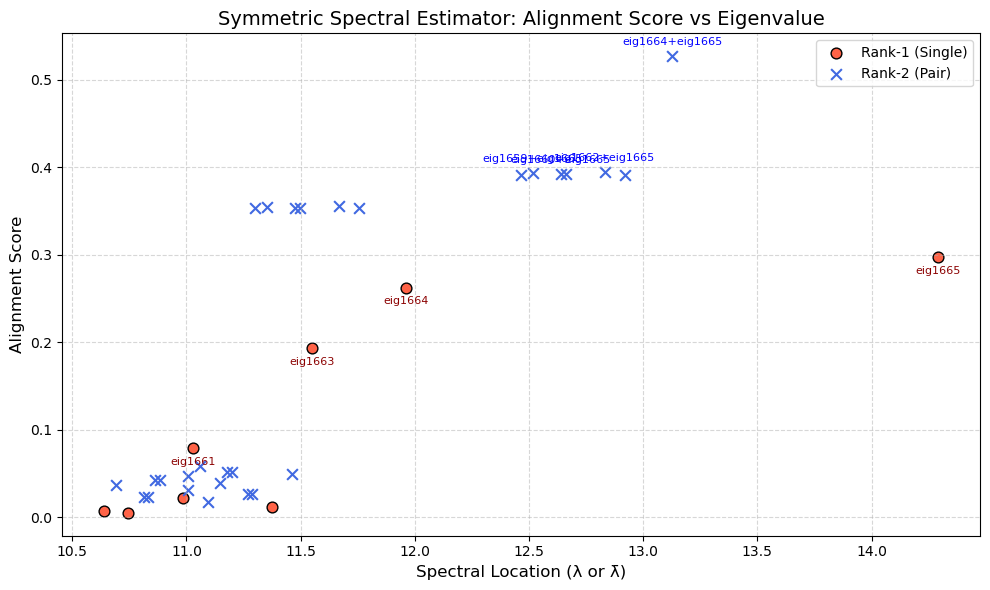

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_alignment_vs_lambda(individual_df, pair_df, top_k=3, title="Alignment Score vs Spectrum Location"):
    """
    Plot the variation of alignment scores for single and paired eigenvectors
    with respect to eigenvalues or spectral locations.

    Parameters:
        individual_df : DataFrame
            Contains columns ['Type', 'λ', 'Alignment Score'] for single eigenvectors.
        pair_df : DataFrame
            Contains columns ['Type', 'λ Pair', 'Alignment Score'] for eigenvector pairs.
        top_k : int, optional
            Number of highest alignment scores to annotate (default: 3).
        title : str, optional
            Title of the plot (default: "Alignment Score vs Spectrum Location").
    """

    # Extract data for single eigenvectors: λ vs alignment score
    lambda_single = individual_df["λ"].values
    score_single = individual_df["Alignment Score"].values
    labels_single = individual_df["Type"].values

    # Extract data for eigenvector pairs: mean λ vs alignment score
    def extract_mean_lambda(val):
        if isinstance(val, str):
            val = eval(val)  # Convert string representation of a tuple to a tuple
        return np.mean(val)

    lambda_pair = pair_df["λ Pair"].apply(extract_mean_lambda).values
    score_pair = pair_df["Alignment Score"].values
    labels_pair = pair_df["Type"].values

    # Visualization
    plt.figure(figsize=(10, 6))

    # Rank-1 points: single eigenvectors
    plt.scatter(lambda_single, score_single, color="tomato", label="Rank-1 (Single)", s=60, edgecolor='black')

    # Rank-2 points: eigenvector pairs
    plt.scatter(lambda_pair, score_pair, color="royalblue", label="Rank-2 (Pair)", marker="x", s=60)

    # Annotate top-k points with highest alignment scores (pairs)
    top_pair_idx = np.argsort(score_pair)[-top_k:]
    for i in top_pair_idx:
        plt.annotate(labels_pair[i], (lambda_pair[i], score_pair[i]),
                     textcoords="offset points", xytext=(0, 8), ha='center', fontsize=8, color='blue')

    # Annotate top-k points with highest alignment scores (single eigenvectors)
    top_single_idx = np.argsort(score_single)[-top_k:]
    for i in top_single_idx:
        plt.annotate(labels_single[i], (lambda_single[i], score_single[i]),
                     textcoords="offset points", xytext=(0, -12), ha='center', fontsize=8, color='darkred')

    # Plot formatting
    plt.xlabel("Spectral Location (λ or λ̄)", fontsize=12)
    plt.ylabel("Alignment Score", fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


plot_alignment_vs_lambda(
    individual_df,
    pair_df,
    top_k=4,
    title="Symmetric Spectral Estimator: Alignment Score vs Eigenvalue"
)


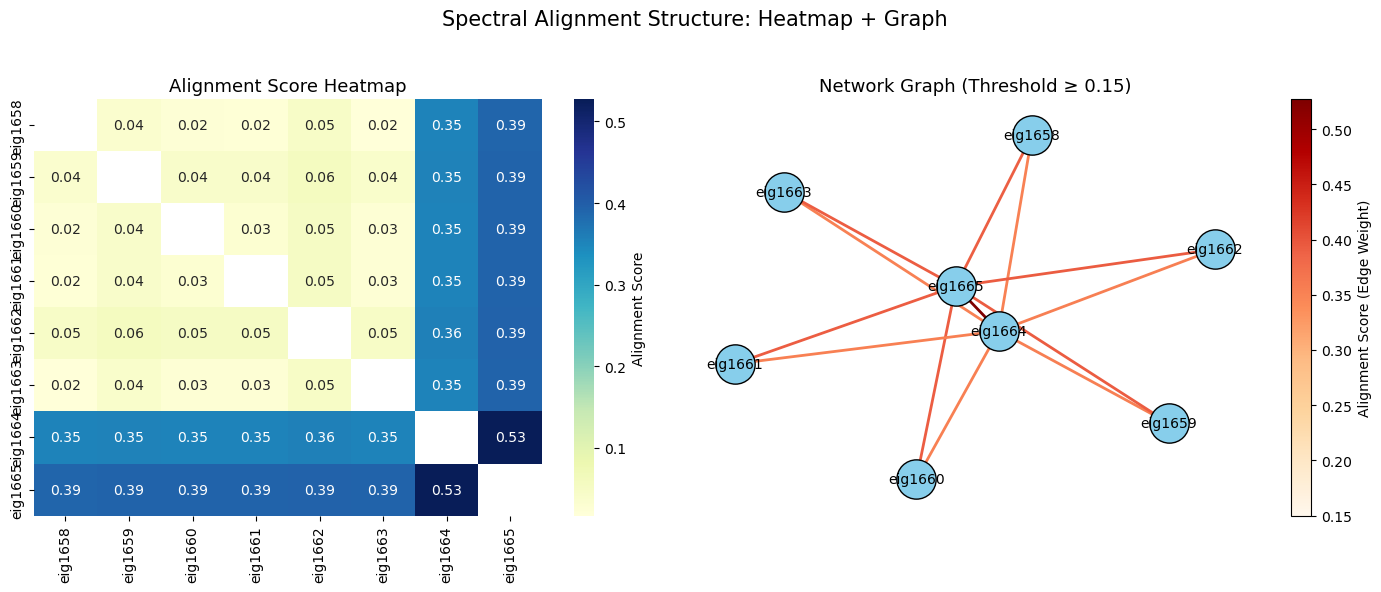

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
import pandas as pd

def plot_heatmap_and_network(pair_df, threshold=0.15,
                             title="Global Spectral Structure: Heatmap + Network"):
    """
    Visualize global spectral alignment structure using a combined heatmap and network graph.

    Parameters
    ----------
    pair_df : pandas.DataFrame
        DataFrame containing ['Type', 'Alignment Score'], where 'Type' is formatted as "eigX+eigY".
    threshold : float, optional
        Minimum alignment score required to draw an edge in the network graph (default: 0.15).
    title : str, optional
        Overall title of the visualization (default: "Global Spectral Structure: Heatmap + Network").
    """

    # Extract all unique eigenvalue labels
    labels = sorted(set([t.split('+')[0] for t in pair_df['Type']] +
                        [t.split('+')[1] for t in pair_df['Type']]))

    # Initialize an empty DataFrame to store heatmap values
    heatmap_df = pd.DataFrame(np.nan, index=labels, columns=labels)

    # Fill alignment scores for all eigenvalue pairs
    for _, row in pair_df.iterrows():
        eig1, eig2 = row["Type"].split("+")
        score = row["Alignment Score"]
        heatmap_df.loc[eig1, eig2] = score
        heatmap_df.loc[eig2, eig1] = score

    # Figure 1: Alignment score heatmap
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={"width_ratios": [1, 1]})
    sns.heatmap(heatmap_df.astype(float), ax=axes[0], annot=True, fmt=".2f",
                cmap="YlGnBu", cbar_kws={"label": "Alignment Score"})
    axes[0].set_title("Alignment Score Heatmap", fontsize=13)

    # Figure 2: Network graph visualization
    G = nx.Graph()
    G.add_nodes_from(labels)

    # Add edges with alignment score above threshold
    for _, row in pair_df.iterrows():
        eig1, eig2 = row["Type"].split("+")
        score = row["Alignment Score"]
        if score >= threshold:
            G.add_edge(eig1, eig2, weight=score)

    pos = nx.spring_layout(G, seed=42)  # Use spring layout for consistent positioning

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, ax=axes[1], node_color="skyblue", node_size=800, edgecolors='black')

    # Draw edges with weights mapped to color intensity
    edges = G.edges(data=True)
    edge_weights = [d['weight'] for (_, _, d) in edges]
    nx.draw_networkx_edges(
        G, pos, ax=axes[1], width=2,
        edge_color=edge_weights, edge_cmap=plt.cm.OrRd,
        edge_vmin=threshold, edge_vmax=max(edge_weights)
    )

    # Draw node labels
    nx.draw_networkx_labels(G, pos, ax=axes[1], font_size=10)

    # Add colorbar for edge weights
    sm = plt.cm.ScalarMappable(cmap=plt.cm.OrRd, norm=plt.Normalize(vmin=threshold, vmax=max(edge_weights)))
    cbar = plt.colorbar(sm, ax=axes[1], fraction=0.046, pad=0.04)
    cbar.set_label("Alignment Score (Edge Weight)")

    axes[1].set_title(f"Network Graph (Threshold ≥ {threshold})", fontsize=13)
    axes[1].axis("off")

    plt.suptitle(title, fontsize=15)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


plot_heatmap_and_network(
    pair_df,
    threshold=0.15,
    title="Spectral Alignment Structure: Heatmap + Graph"
)


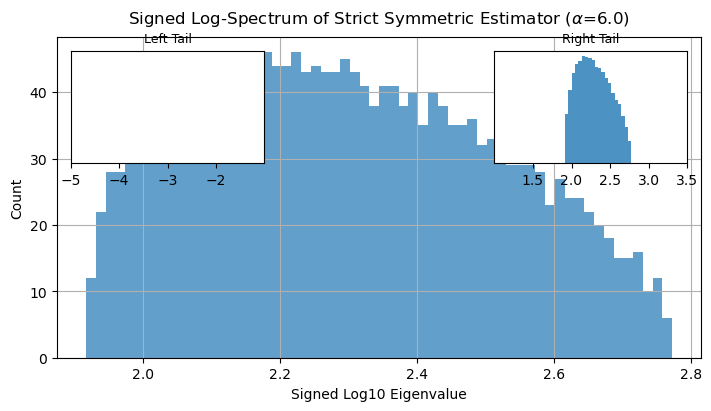

In [16]:
fig, ax = plt.subplots(figsize=(7, 4), constrained_layout=True)  # ✅ 替代 tight_layout
ax.hist(log_signed, bins=60, alpha=0.7)
ax.set_title(f"Signed Log-Spectrum of Strict Symmetric Estimator ($\\alpha$={alpha:.1f})", pad=10)
ax.set_xlabel("Signed Log10 Eigenvalue")
ax.set_ylabel("Count")
ax.grid(True)

log_signed = np.sign(eigvals_np) * np.log10(np.abs(eigvals_np) + 1e-12)

# Left inset
ax_left = inset_axes(ax, width="30%", height="35%", loc='upper left', borderpad=1)
ax_left.hist(left_tail, bins=20, color='tab:blue', alpha=0.8)
ax_left.set_xlim(-5, -1)
ax_left.set_xticks([-5, -4, -3, -2])
ax_left.set_yticks([])
ax_left.set_title("Left Tail", fontsize=9)

# Right inset
ax_right = inset_axes(ax, width="30%", height="35%", loc='upper right', borderpad=1)
ax_right.hist(right_tail, bins=20, color='tab:blue', alpha=0.8)
ax_right.set_xlim(1, 3)
ax_right.set_xticks([1.5, 2.0, 2.5,3,3.5])
ax_right.set_yticks([])
ax_right.set_title("Right Tail", fontsize=9)

plt.show()


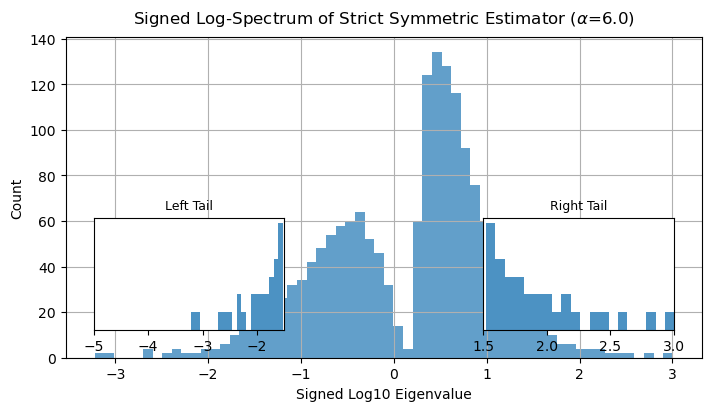

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.special import kv as besselk
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Parameter configuration
n, p, alpha, alpha_c = 5000, 2, 6, 0.59375
d = int(n / alpha)
R = np.sqrt(alpha / alpha_c)

# Data generation
torch.manual_seed(42)
np.random.seed(42)
W_star = torch.nn.functional.normalize(torch.randn(d, p), dim=0)
X = torch.randn(n, d)
Z = X @ W_star
y = Z[:, 0] * Z[:, 1]
y_np = y.numpy()

# Construction of G(y)
abs_y = np.abs(y_np)
K0 = besselk(0, abs_y)
K1 = besselk(1, abs_y)
lambda_y = abs_y * (K1 / (K0 + 1e-6)) - 1
lambda_y[np.isnan(lambda_y)] = 0

# Construct G_y
G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y

# Construction of L_sym
L = torch.zeros((2 * d, 2 * d))
I_p = torch.eye(p)
for i in range(n):
    x_i = X[i].view(d, 1)
    kron_x = torch.kron(I_p, x_i)  # Shape: (2d, p)
    T_yi = torch.tensor(G_y_np[i], dtype=torch.float32)  # Shape: (p, p)
    L += kron_x @ T_yi @ kron_x.T
L /= n

# Eigenvalue decomposition
eigvals, eigvecs = torch.linalg.eigh(L)
eigvals_np = eigvals.numpy()

# Signed log spectrum
log_signed = np.sign(eigvals_np) * np.log10(np.abs(eigvals_np) + 1e-12)
left_tail = log_signed[log_signed < -1.5]
right_tail = log_signed[log_signed > 1.5]

# Visualization
fig, ax = plt.subplots(figsize=(7, 4), constrained_layout=True)
ax.hist(log_signed, bins=60, alpha=0.7)
ax.set_title(f"Signed Log-Spectrum of Strict Symmetric Estimator ($\\alpha$={alpha:.1f})", pad=10)
ax.set_xlabel("Signed Log10 Eigenvalue")
ax.set_ylabel("Count")
ax.grid(True)

# Left inset: negative tail
ax_left = inset_axes(ax, width="30%", height="35%", loc='lower left', borderpad=2)
ax_left.hist(left_tail, bins=20, color='tab:blue', alpha=0.8)
ax_left.set_xlim(-5, -1.5)
ax_left.set_xticks([-5, -4, -3, -2])
ax_left.set_yticks([])
ax_left.set_title("Left Tail", fontsize=9)

# Right inset: positive tail
ax_right = inset_axes(ax, width="30%", height="35%", loc='lower right', borderpad=2)
ax_right.hist(right_tail, bins=20, color='tab:blue', alpha=0.8)
ax_right.set_xlim(1.5, 2)
ax_right.set_xticks([1.5, 2.0, 2.5, 3])
ax_right.set_yticks([])
ax_right.set_title("Right Tail", fontsize=9)

plt.show()


In [ ]:
from itertools import combinations
import numpy as np
import pandas as pd
import torch

# Unified evaluation of eigenvector and subspace alignment
def elevate_vector(v, position='top', d=None):
    if d is None:
        d = v.shape[0]
    if position == 'top':
        return np.concatenate([v, np.zeros(d)])
    else:
        return np.concatenate([np.zeros(d), v])

def evaluate_alignment_unified(eig_vals, eig_vecs, W_star, top_k=8, mode='symmetric'):
    """
    Evaluate alignment scores for individual eigenvectors and eigenvector pairs.

    Parameters
    ----------
    eig_vals : ndarray
        Eigenvalues of the spectral estimator.
    eig_vecs : ndarray
        Corresponding eigenvectors, shape (2d, 2d).
    W_star : torch.Tensor
        Ground-truth signal subspace, shape (d, p).
    top_k : int, optional
        Number of leading eigenvectors to evaluate (default: 8).
    mode : {'symmetric', 'asymmetric'}, optional
        Evaluation mode (default: 'symmetric').

    Returns
    -------
    individual_df : pandas.DataFrame
        Alignment scores for individual eigenvectors.
    pair_df : pandas.DataFrame
        Subspace alignment scores for eigenvector pairs.
    """
    d, p = W_star.shape
    W_sym_np = elevate_W_star_to_symmetric(W_star.numpy())
    Q_true, _ = np.linalg.qr(W_sym_np[:, :p])  # Use first p columns for the true signal subspace

    # Select top-k eigenvalues
    indices = np.argsort(eig_vals)[-top_k:]
    individual_scores = []

    for i in indices:
        vec = eig_vecs[:, i]  # Single eigenvector, shape (2d,)

        # Reshape into a d × 2 matrix
        try:
            V = vec.reshape(2, d).T  # Shape: (d, 2)
        except:
            print(f"Error reshaping eigenvector {i}, shape = {vec.shape}")
            continue

        # Elevate into 2d × 2 representation for alignment
        W_est = elevate_W_star_to_symmetric(V)  # Shape: (2d, 2)
        Q_est, _ = np.linalg.qr(W_est)
        overlap = Q_est.T @ Q_true
        align_score = np.linalg.norm(overlap, 'fro')**2 / p
        individual_scores.append((f"eig{i}", eig_vals[i], align_score))

    # Pairwise subspace alignment
    pair_scores = []
    for i, j in combinations(indices, 2):
        vi = eig_vecs[:, i]
        vj = eig_vecs[:, j]
        if mode == 'asymmetric':
            vi = elevate_vector(vi, 'top', d=d)
            vj = elevate_vector(vj, 'top', d=d)
        V = np.stack([vi, vj], axis=1)
        Q, _ = np.linalg.qr(V)
        Q_torch = torch.tensor(Q, dtype=torch.float32)
        W_sym = torch.tensor(W_sym_np, dtype=torch.float32)
        proj = Q_torch @ Q_torch.T @ W_sym
        align_score = (torch.norm(proj) / torch.norm(W_sym)).item()
        pair_scores.append((f"eig{i}+eig{j}", (eig_vals[i], eig_vals[j]), align_score))

    individual_df = pd.DataFrame(individual_scores, columns=["Type", "λ", "Alignment Score"])
    pair_df = pd.DataFrame(pair_scores, columns=["Type", "λ Pair", "Alignment Score"])
    return individual_df, pair_df


# Run unified evaluation
eigvals_np = eigvals_sym.numpy()
eigvecs_np = eigvecs_sym.numpy()

individual_df, pair_df = evaluate_alignment_unified(
    eigvals_np, eigvecs_np, W_star, top_k=8, mode='symmetric'
)

print("\n[Individual Eigenvector Alignment Scores]")
print(individual_df.round(4))

print("\n[Eigenvector Pair Subspace Alignment Scores]")
print(pair_df.round(4))



[Individual Eigenvector Alignment Scores]
      Type        λ  Alignment Score
0  eig1658  10.6393           0.0068
1  eig1659  10.7424           0.0051
2  eig1660  10.9844           0.0223
3  eig1661  11.0279           0.0787
4  eig1662  11.3725           0.0120
5  eig1663  11.5500           0.1934
6  eig1664  11.9629           0.2627
7  eig1665  14.2920           0.2973

[Eigenvector Pair Subspace Alignment Scores]
               Type                  λ Pair  Alignment Score
0   eig1658+eig1659  (10.639304, 10.742441)           0.0369
1   eig1658+eig1660  (10.639304, 10.984408)           0.0234
2   eig1658+eig1661  (10.639304, 11.027896)           0.0232
3   eig1658+eig1662  (10.639304, 11.372451)           0.0471
4   eig1658+eig1663  (10.639304, 11.549953)           0.0173
5   eig1658+eig1664  (10.639304, 11.962899)           0.3530
6   eig1658+eig1665  (10.639304, 14.292014)           0.3916
7   eig1659+eig1660  (10.742441, 10.984408)           0.0423
8   eig1659+eig1661  (10.7424

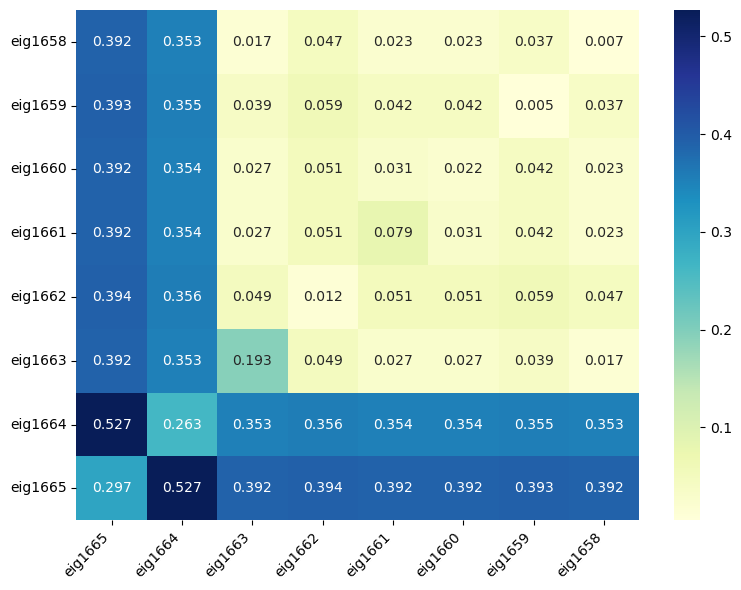

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_alignment_heatmap(pair_df, individual_df):
    """
    Plot the alignment heatmap for the symmetric spectral estimator.

    The x-axis is ordered from eig3999 → eig3992,
    and the y-axis from eig3992 → eig3999.
    No figure title is included.

    Parameters
    ----------
    pair_df : pandas.DataFrame
        DataFrame containing eigenvalue pair alignment scores,
        with columns ['Type', 'Alignment Score'], where 'Type' has the form "eigX+eigY".
    individual_df : pandas.DataFrame
        DataFrame containing alignment scores for individual eigenvectors,
        with columns ['Type', 'Alignment Score'].

    Returns
    -------
    heatmap_df : pandas.DataFrame
        Symmetric matrix of alignment scores for visualization.
    """
    # Extract all unique eigenvalue labels
    labels = sorted(set([t.split('+')[0] for t in pair_df['Type']] + 
                        [t.split('+')[1] for t in pair_df['Type']]))

    # Initialize symmetric DataFrame to store alignment scores
    heatmap_df = pd.DataFrame(np.nan, index=labels, columns=labels)

    # Fill alignment scores for eigenvalue pairs
    for _, row in pair_df.iterrows():
        e1, e2 = row["Type"].split("+")
        score = row["Alignment Score"]
        heatmap_df.loc[e1, e2] = score
        heatmap_df.loc[e2, e1] = score

    # Fill diagonal with individual eigenvector alignment scores
    for idx in labels:
        value = individual_df[individual_df["Type"] == idx]["Alignment Score"].values[0]
        heatmap_df.loc[idx, idx] = value

    # Reverse column order for x-axis visualization
    reversed_cols = labels[::-1]

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        heatmap_df.loc[:, reversed_cols].astype(float),
        annot=True, fmt=".3f", cmap="YlGnBu", cbar=True,
        xticklabels=reversed_cols, yticklabels=labels
    )

    # Configure axis labels without adding a title
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return heatmap_df

# Call the function to plot the heatmap
heatmap_df = plot_alignment_heatmap(pair_df, individual_df)


### Negative Half-Shaft Evaluation

In [ ]:
from itertools import combinations

def evaluate_alignment_custom(eig_vals, eig_vecs, W_star, indices, mode='symmetric'):
    """
    对自定义谱点（支持负轴）评估其子空间对齐度
    """
    d, p = W_star.shape

    def elevate_W_star_to_symmetric(W):
        return np.vstack([
            np.hstack([W, np.zeros_like(W)]),
            np.hstack([np.zeros_like(W), W])
        ])

    def elevate_vector(v, position='top'):
        return np.concatenate([v, np.zeros_like(v)]) if position == 'top' else np.concatenate([np.zeros_like(v), v])

    W_sym_np = elevate_W_star_to_symmetric(W_star.numpy())
    Q_true, _ = np.linalg.qr(W_sym_np[:, :p])

    individual_scores = []
    for i in indices:
        vec = eig_vecs[:, i]
        try:
            V = vec.reshape(2, d).T
        except:
            print(f"Skip eig{i}: reshape error")
            continue
        W_est = elevate_W_star_to_symmetric(V)
        Q_est, _ = np.linalg.qr(W_est)
        overlap = Q_est.T @ Q_true
        score = np.linalg.norm(overlap, 'fro')**2 / p
        individual_scores.append((f"eig{i}", eig_vals[i], score))

    pair_scores = []
    for i, j in combinations(indices, 2):
        vi, vj = eig_vecs[:, i], eig_vecs[:, j]
        if mode == 'asymmetric':
            vi = elevate_vector(vi, 'top')
            vj = elevate_vector(vj, 'top')
        V = np.stack([vi, vj], axis=1)
        Q, _ = np.linalg.qr(V)
        proj = Q @ Q.T @ W_sym_np
        score = np.linalg.norm(proj) / np.linalg.norm(W_sym_np)
        pair_scores.append((f"eig{i}+eig{j}", (eig_vals[i], eig_vals[j]), score))

    individual_df = pd.DataFrame(individual_scores, columns=["Type", "λ", "Alignment Score"])
    pair_df = pd.DataFrame(pair_scores, columns=["Type", "λ Pair", "Alignment Score"])
    return individual_df, pair_df

# 再次执行你已有的调用
ind_df_neg, pair_df_neg = evaluate_alignment_custom(
    eigvals_np, eigvecs_sym.numpy(), W_star, indices=negative_jump_indices
)

print(ind_df_neg.round(4))
print(pair_df_neg.round(4))


       Type       λ  Alignment Score
0      eig0 -0.3632           0.3589
1      eig1 -0.3632           0.3006
2      eig2 -0.3564           0.0061
3      eig3 -0.3564           0.2206
4      eig4 -0.3466           0.0207
..      ...     ...              ...
126  eig126 -0.2004           0.0006
127  eig127 -0.2004           0.0034
128  eig128 -0.1992           0.0019
129  eig129 -0.1992           0.0013
130  eig130 -0.1971           0.0015

[131 rows x 3 columns]
               Type                      λ Pair  Alignment Score
0         eig0+eig1  (-0.36323568, -0.36323562)           0.5681
1         eig0+eig2   (-0.36323568, -0.3564174)           0.4324
2         eig0+eig3   (-0.36323568, -0.3564174)           0.4312
3         eig0+eig4  (-0.36323568, -0.34659234)           0.4333
4         eig0+eig5   (-0.36323568, -0.3465923)           0.4296
...             ...                         ...              ...
8510  eig127+eig129  (-0.20044221, -0.19921568)           0.0457
8511  eig127

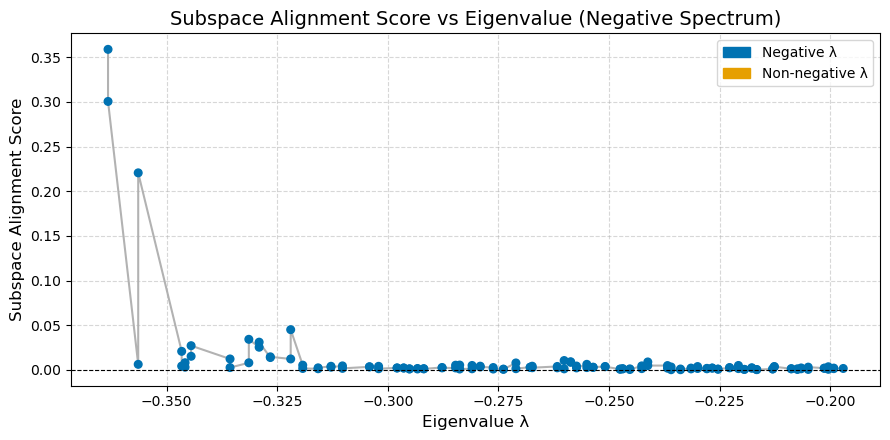

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_alignment_trend(ind_df, title="Alignment Score across Spectrum"):
    """
    Plot the trend of subspace alignment scores across eigenvalues,
    including the negative spectrum.

    Parameters
    ----------
    ind_df : pandas.DataFrame
        DataFrame containing columns ['λ', 'Alignment Score'] for individual eigenvectors.
    title : str, optional
        Title of the plot (default: "Alignment Score across Spectrum").
    """
    # Sort by eigenvalues in ascending order (negative to positive)
    df_sorted = ind_df.sort_values(by="λ")
    
    # Extract eigenvalues and alignment scores
    lambdas = df_sorted["λ"].values
    scores = df_sorted["Alignment Score"].values
    
    # Assign colors based on the sign of eigenvalues
    colors = ["#0072B2" if l < 0 else "#E69F00" for l in lambdas]
    
    # Plot alignment scores vs. eigenvalues
    fig, ax = plt.subplots(figsize=(9, 4.5))
    ax.plot(lambdas, scores, color='gray', alpha=0.6, lw=1.5, zorder=1)
    ax.scatter(lambdas, scores, c=colors, s=30, zorder=2)
    
    # Reference horizontal line at y=0
    ax.axhline(y=0, color='black', lw=0.8, linestyle='--')
    
    # Axis labels and title
    ax.set_xlabel("Eigenvalue λ", fontsize=12)
    ax.set_ylabel("Subspace Alignment Score", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Legend for negative and non-negative eigenvalues
    from matplotlib.patches import Patch
    legend_handles = [
        Patch(color='#0072B2', label="Negative λ"),
        Patch(color='#E69F00', label="Non-negative λ")
    ]
    ax.legend(handles=legend_handles, loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Example usage for negative spectrum evaluation
plot_alignment_trend(
    ind_df_neg,
    title="Subspace Alignment Score vs Eigenvalue (Negative Spectrum)"
)


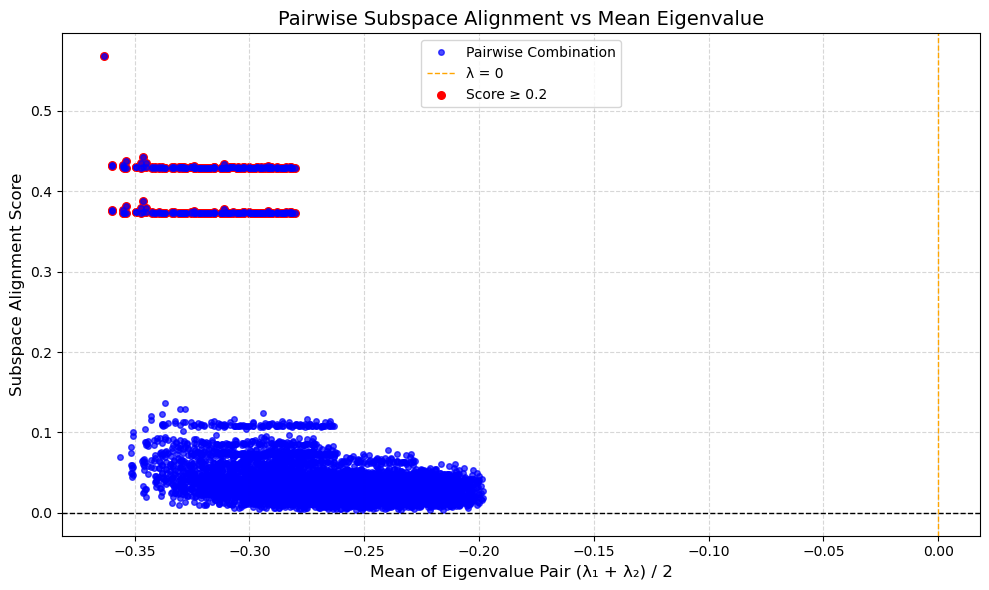

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def compute_mean_lambda(pair_df):
    """
    Compute the mean eigenvalue for each eigenvalue pair.

    Parameters
    ----------
    pair_df : pandas.DataFrame
        DataFrame containing ['Type', 'λ Pair', 'Alignment Score'].

    Returns
    -------
    pair_df : pandas.DataFrame
        Updated DataFrame with an additional column 'Mean λ'.
    """
    lambda_means = []
    for pair in pair_df["λ Pair"]:
        mean_val = sum(pair) / 2
        lambda_means.append(mean_val)
    pair_df["Mean λ"] = lambda_means
    return pair_df


def plot_pairwise_alignment_vs_mean(pair_df, score_thresh=0.2):
    """
    Plot pairwise subspace alignment scores as a function of the mean eigenvalue.

    Parameters
    ----------
    pair_df : pandas.DataFrame
        DataFrame containing ['Mean λ', 'Alignment Score'].
    score_thresh : float, optional
        Threshold for highlighting high-alignment pairs (default: 0.2).
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    # Scatter plot of all eigenvalue pairs
    ax.plot(pair_df["Mean λ"], pair_df["Alignment Score"], 'o',
            color='blue', markersize=4, alpha=0.7, label='Pairwise Combination')

    # Reference lines
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.axvline(0, color='orange', linestyle='--', linewidth=1, label='λ = 0')

    # Highlight high-alignment pairs
    high_idx = pair_df["Alignment Score"] >= score_thresh
    ax.scatter(pair_df.loc[high_idx, "Mean λ"],
               pair_df.loc[high_idx, "Alignment Score"],
               color='red', s=30, label=f'Score ≥ {score_thresh}')

    # Labels and formatting
    ax.set_title("Pairwise Subspace Alignment vs Mean Eigenvalue", fontsize=14)
    ax.set_xlabel("Mean of Eigenvalue Pair (λ₁ + λ₂) / 2", fontsize=12)
    ax.set_ylabel("Subspace Alignment Score", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()


pair_df_all = compute_mean_lambda(pair_df_neg)  # Replace with your variable name
plot_pairwise_alignment_vs_mean(pair_df_all, score_thresh=0.2)
